# 기본코드

개선을 진행하기전 베이스 코드입니다.

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 


import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)


# 모든 컬럼 출력 설정
pd.set_option('display.max_columns', None)
# 모든 행 출력 설정
pd.set_option('display.max_rows', None)

import module


In [3]:
subway_df = module.file_load.load_지하철()
bus_df = module.file_load.load_버스()
subway_df = subway_df.rename(columns={'위도': 'y', '경도': 'x'})
bus_df = bus_df.rename(columns={'Y좌표': 'y', 'X좌표': 'x'})

# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
dt = module.file_load.loadVersionOfData('train_v30')
dt_test = module.file_load.loadVersionOfData('test_v30')
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 94) Test data shape :  (9272, 94)


In [4]:
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test]) 

In [5]:
drop_columns1 = ['k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드','해제사유발생일', '등기신청일자', '거래유형', '중개사소재지','단지신청일' ]

In [6]:
concat = module.preprocess.rename(concat) # 컬럼명을 변경해줍니다.
concat = module.preprocess.remove_outliers_iqr(concat, '전용면적')

module.preprocess.아파트_unique_key_add(concat) # 아파트 고유 키를 만들어줍니다.
module.preprocess.해제사유발생유무_add(concat) # 해제사유 발생 유무 컬럼을 추가합니다.
module.preprocess.번지_본번_부번_결측채우기(concat) # 번지, 본번, 부번을 결측치를 채워줍니다.
module.preprocess.계약년월일(concat) #
module.preprocess.강남_add(concat)
module.preprocess.신축_add(concat)
module.preprocess.탑층_add(concat)
module.preprocess.층그룹_add(concat)
module.preprocess.평수그룹_add(concat)
module.preprocess.생활지수파생변수(concat)

concat = module.preprocess.테스트_최대평수이상제거(concat)
concat = module.preprocess.테스트_최대층이상제거(concat)
concat = module.preprocess.건축년도_계약년도_앞서면제거(concat)
concat = module.preprocess.target이상치제거(concat) 
module.preprocess.공원밀도_add(concat)
# 호선 정보 추가
unique_apt = concat.drop_duplicates(subset='아파트_unique_key', keep='first')
unique_apt2 = module.preprocess.nearest_subway_name(unique_apt, subway_df, '호선')[['아파트_unique_key','호선']]
concat = concat.merge(unique_apt2[['아파트_unique_key', '호선']], on='아파트_unique_key', how='left')

module.preprocess.한강거리_add(concat)
concat['한강근접'] = concat['한강거리'].apply(lambda x: 1 if x < 800 else 0)

module.preprocess.고급아파트_추가(concat)
concat = module.preprocess.비싼아파트_add(concat)

concat['재건축30'] = concat['경과연도'] >= 30

concat = module.preprocess.아파트주변정보(concat)


21.68500000000001
122.92499999999998


In [7]:
concat_temp = concat.copy()

In [89]:
concat = concat_temp.copy()

In [90]:
module.preprocess.log처리(concat)

In [91]:
# # '번지', '아파트명', '계약년월', '계약일', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
#        '금리_단기1년전차이', 'nearest_subway_distance', 'nearest_bus_distance',
#        '1차역세권', '2차역세권', '1차버스정류장', '경과연도', '평수', '구', '동', '아파트ID', '아파트ID거리',
#        'nearest_park_distance', '가까운공원ID', '산책생활권점수', '한강지천길갯수', '한강지천길총길이',
#        '한강지천생활권점수', '숲세권등급', '한강거리', '실업률', 'is_test', '해제사유발생유무', '강남여부',
#        '건물연령구분', 'is_top', '산책로밀도', '생태문화길밀도', '공원밀도', '호선', '한강근접', '비싼아파트',
#        '재건축30', '학원', '학교', '공공기관', '병원', '어린이집, 유치원', '계약년'

In [100]:
final_drop = [
'index', '시군구','본번', '부번','전용면적', '경과구분','층_그룹', '평수_그룹','시',
'가까운공원이름','아파트_unique_key',
'계약년월일','지가지수', 
'아파트전세_전기대비증감률',  '민간소비', '소비자심리지수', '경제심리지수', '여수신 금리차','음식점','편의점', '생태문화생활권점수'
, '고급아파트','숲세권종합점수', '공원생활권점수', '공원갯수', '공원총면적'
]

In [101]:
concat_select = concat.drop(columns=drop_columns1)

In [102]:
model_data = concat_select.drop(columns=final_drop)

In [103]:
# 필터링을 위해 넣음
model_data['계약년'] = model_data["계약년월"].astype(str).str[:4]
model_data['계약년'] = model_data['계약년'].astype(int)

In [104]:
model_data.columns

Index(['번지', '아파트명', '계약년월', '계약일', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
       '금리_단기1년전차이', 'nearest_subway_distance', 'nearest_bus_distance',
       '1차역세권', '2차역세권', '1차버스정류장', '경과연도', '평수', '구', '동', '아파트ID', '아파트ID거리',
       'nearest_park_distance', '가까운공원ID', '산책생활권점수', '한강지천길갯수', '한강지천길총길이',
       '한강지천생활권점수', '숲세권등급', '한강거리', '실업률', 'is_test', '해제사유발생유무', '강남여부',
       '건물연령구분', 'is_top', '산책로밀도', '생태문화길밀도', '공원밀도', '호선', '한강근접', '비싼아파트',
       '재건축30', '학원', '학교', '공공기관', '병원', '어린이집, 유치원', '계약년'],
      dtype='object')

In [105]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036984 entries, 0 to 1036983
Data columns (total 49 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   번지                       1036984 non-null  object 
 1   아파트명                     1036984 non-null  object 
 2   계약년월                     1036984 non-null  int64  
 3   계약일                      1036984 non-null  int64  
 4   층                        1036984 non-null  int64  
 5   건축년도                     1036984 non-null  int64  
 6   도로명                      1036984 non-null  object 
 7   좌표X                      1036984 non-null  float64
 8   좌표Y                      1036984 non-null  float64
 9   target                   1027712 non-null  float64
 10  금리_단기1년전차이               1036984 non-null  float64
 11  nearest_subway_distance  1036984 non-null  float64
 12  nearest_bus_distance     1036984 non-null  float64
 13  1차역세권                    1036984 non-null 

# 모델


In [106]:
from sklearn.model_selection import TimeSeriesSplit

dt_train = model_data.query('is_test==0')
dt_test = model_data.query('is_test==1')
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
dt_train.shape, dt_test.shape


((1027712, 48), (9272, 48))

In [107]:
module.preprocess.label_encoding(dt_train, dt_test)

연속형 변수: ['계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', '금리_단기1년전차이', 'nearest_subway_distance', 'nearest_bus_distance', '1차역세권', '2차역세권', '1차버스정류장', '경과연도', '평수', '아파트ID거리', 'nearest_park_distance', '산책생활권점수', '한강지천길갯수', '한강지천길총길이', '한강지천생활권점수', '숲세권등급', '한강거리', '실업률', '해제사유발생유무', '강남여부', 'is_top', '산책로밀도', '생태문화길밀도', '공원밀도', '한강근접', '비싼아파트', '재건축30', '학원', '학교', '공공기관', '병원', '어린이집, 유치원', '계약년']
범주형 변수: ['번지', '아파트명', '도로명', '구', '동', '아파트ID', '가까운공원ID', '건물연령구분', '호선']


100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


In [113]:
from sklearn.ensemble import IsolationForest

# 1. 2023년 이상 데이터 필터링
dt_train_2023 = dt_train[dt_train['계약년'] >= 2023]
print(f"2023년 이상 데이터 개수: {dt_train_2023.shape[0]}")

# 2. IsolationForest로 이상치 탐지
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=2023)
dt_train_2023['anomaly_score'] = isolation_forest.fit_predict(dt_train_2023)

# 3. 이상치와 일반 데이터 분리
dt_anomalies = dt_train_2023[dt_train_2023['anomaly_score'] == -1]  # 이상치
dt_normal = dt_train_2023[dt_train_2023['anomaly_score'] != -1]    # 일반 데이터

print(f"이상치 데이터 개수: {dt_anomalies.shape[0]}")
print(f"일반 데이터 개수: {dt_normal.shape[0]}")

# 4. 500개 이상치 샘플링
num_anomalies = min(500, len(dt_anomalies))
dt_sample_anomalies = dt_anomalies.sample(n=num_anomalies, random_state=2023)

# 5. 4500개 일반 데이터 샘플링
num_normal = 5000 - num_anomalies
dt_sample_normal = dt_normal.sample(n=num_normal, random_state=2023)

# 6. 최종 샘플 결합
dt_sample = pd.concat([dt_sample_anomalies, dt_sample_normal])

# 7. dt_train 재구성 (dt_sample에 포함되지 않은 데이터)
dt_train = dt_train[~dt_train.index.isin(dt_sample.index)]

dt_sample.drop(columns=['anomaly_score'], inplace=True)

# 결과 확인
print("최종 샘플 데이터 크기:", dt_sample.shape)
print("재구성된 dt_train 크기:", dt_train.shape)
print("이상치 샘플 개수:", dt_sample_anomalies.shape[0])
print("일반 샘플 개수:", dt_sample_normal.shape[0])


2023년 이상 데이터 개수: 15873
이상치 데이터 개수: 794
일반 데이터 개수: 15079
최종 샘플 데이터 크기: (5000, 48)
재구성된 dt_train 크기: (1022712, 48)
이상치 샘플 개수: 500
일반 샘플 개수: 4500


In [114]:
print("특이한 데이터 샘플 수:", dt_sample.shape)
print("재구성된 dt_train 크기:", dt_train.shape)

특이한 데이터 샘플 수: (5000, 48)
재구성된 dt_train 크기: (1022712, 48)


In [115]:
dt_sample.columns, dt_train.columns

(Index(['번지', '아파트명', '계약년월', '계약일', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
        '금리_단기1년전차이', 'nearest_subway_distance', 'nearest_bus_distance',
        '1차역세권', '2차역세권', '1차버스정류장', '경과연도', '평수', '구', '동', '아파트ID', '아파트ID거리',
        'nearest_park_distance', '가까운공원ID', '산책생활권점수', '한강지천길갯수', '한강지천길총길이',
        '한강지천생활권점수', '숲세권등급', '한강거리', '실업률', '해제사유발생유무', '강남여부', '건물연령구분',
        'is_top', '산책로밀도', '생태문화길밀도', '공원밀도', '호선', '한강근접', '비싼아파트', '재건축30',
        '학원', '학교', '공공기관', '병원', '어린이집, 유치원', '계약년'],
       dtype='object'),
 Index(['번지', '아파트명', '계약년월', '계약일', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
        '금리_단기1년전차이', 'nearest_subway_distance', 'nearest_bus_distance',
        '1차역세권', '2차역세권', '1차버스정류장', '경과연도', '평수', '구', '동', '아파트ID', '아파트ID거리',
        'nearest_park_distance', '가까운공원ID', '산책생활권점수', '한강지천길갯수', '한강지천길총길이',
        '한강지천생활권점수', '숲세권등급', '한강거리', '실업률', '해제사유발생유무', '강남여부', '건물연령구분',
        'is_top', '산책로밀도', '생태문화길밀도', '공원밀도', '호선', '한강근접', '비싼아파트'

In [116]:
# Target과 독립변수 분리
y = dt_train['target']
X = dt_train.drop(['target'], axis=1)
# Time Series Split 설정 (5개 분할)
tscv = TimeSeriesSplit(n_splits=12)
# 마지막 분할을 사용하여 train/val 분리
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((944042, 47), (78670, 47), (944042,), (78670,))

In [117]:
X_train.isnull().sum()

번지                         0
아파트명                       0
계약년월                       0
계약일                        0
층                          0
건축년도                       0
도로명                        0
좌표X                        0
좌표Y                        0
금리_단기1년전차이                 0
nearest_subway_distance    0
nearest_bus_distance       0
1차역세권                      0
2차역세권                      0
1차버스정류장                    0
경과연도                       0
평수                         0
구                          0
동                          0
아파트ID                      0
아파트ID거리                    0
nearest_park_distance      0
가까운공원ID                    0
산책생활권점수                    0
한강지천길갯수                    0
한강지천길총길이                   0
한강지천생활권점수                  0
숲세권등급                      0
한강거리                       0
실업률                        0
해제사유발생유무                   0
강남여부                       0
건물연령구분                     0
is_top                     0
산책로밀도         

In [118]:
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')
# RMSE test: 13750.323952543033

RMSE test: 13750.323952543033


In [119]:
# Target과 독립변수들을 분리해줍니다.
y_test_sample = dt_sample['target'] # 맞추어야 할 대상, 주택 가격
X_test_sample = dt_sample.drop(['target'], axis=1) # 독립변수들, 번지, 면적,층,년도 등등..

In [120]:
X_test_sample.shape, y_test_sample.shape

((5000, 47), (5000,))

In [121]:
pred_sample = model.predict(X_test_sample)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_test_sample, pred_sample))}')
# RMSE test: 11844.032735556266

RMSE test: 11844.032735556266


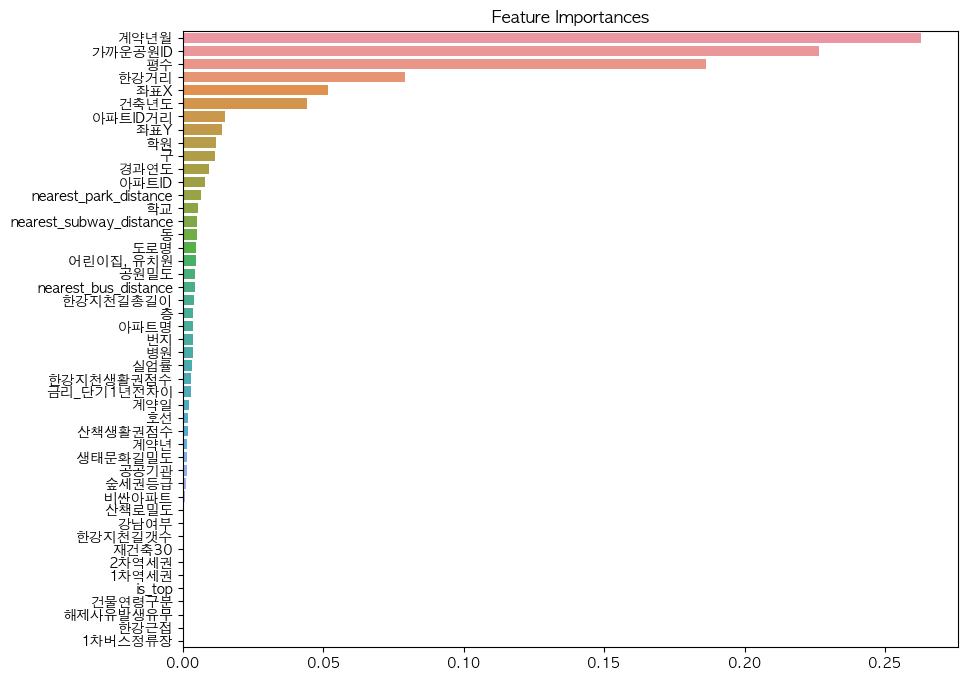

In [122]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()